# 1. Monte Carlo Methods

The Monte Carlo method is a computational algorithm that relies on repeated random sampling to obtain numerical results. The basic idea is to use randomness to solve problems that might be deterministic in principle. Monte Carlo methods are used in various fields such as physics, finance, and engineering for numerical integration, optimization, and simulation.

## 1.1 Key Concepts
1. **Random Sampling:**  Randomly generating inputs to a function to simulate a process.
2. **Statistical Analysis:** Using the results of random sampling to infer properties of the function or process.
3. **Law of Large Numbers:** The more samples you use, the closer the estimate will be to the true value.

Given i.i.d. random variables $X_1, \ldots, X_n$. We define the mean
\begin{equation*}
\bar{X}:= \frac{1}{n} \sum_{i=1}^{n} X_i.
\end{equation*}

By the strong law of large numbers it holds:
\begin{equation}
\bar{X} \rightarrow \mathbb{E}[X] \ \ \textit{a.s.}
\end{equation}

A basic **Monte Carlo (MC) simualtion** for $n$ i.i.d. copies of a given random variable $X$ uses the estimator $\bar{X}$ for estimating the mean $\mathbb{E}[X]$.

Let us consider a function $f:\mathbb{R}^n \rightarrow \mathbb{R}^m$ (measurable) that represents the model that we are interested in, i.e. the source location of a tsunami. If we like to estimate $\mathbb{E}[f(X)]$ the MC estimator is given by 
\begin{equation}
\hat{F}^{MC} = \frac{1}{n} \sum_{i=1}^{n} f(X_i).
\end{equation}

**UM-Bridge context:** The model function $f$ represents the **server** side while we refer to the MC estimator $\hat{F}^{MC}$ as the **client**.

In the following we give some basic MC simulation for a sample of normal distributed random variables.

In [81]:
import numpy as np
import matplotlib.pyplot as plt

# Set the number of random variables
N = 1000

# Generate N normal distributed random variables between 0 and 1
X = np.random.normal(loc=0.5, scale=0.1, size=N)

# Calculate the mean of the random variables
mean_X = np.mean(X)

# Expected value for a normal distribution with mean = 0.5
expected_value = 0.5

print(f"Calculated mean: {mean_X}")
print(f"Expected mean: {expected_value}")

Calculated mean: 0.5012927824665311
Expected mean: 0.5


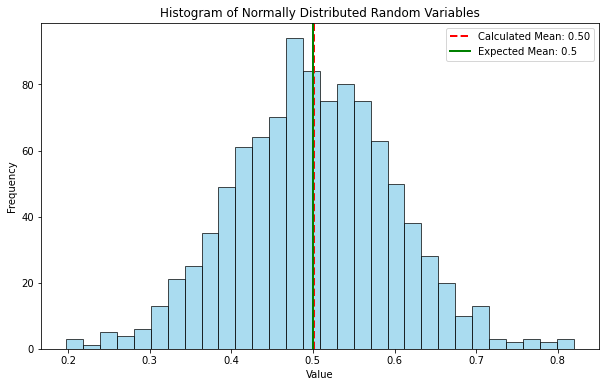

In [82]:
# Plot
plt.figure(figsize=(10, 6))
plt.hist(X, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(mean_X, color='red', linestyle='dashed', linewidth=2, label=f'Calculated Mean: {mean_X:.2f}')
plt.axvline(expected_value, color='green', linestyle='solid', linewidth=2, label='Expected Mean: 0.5')
plt.title('Histogram of Normally Distributed Random Variables')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()

plt.show()

## 1.2 UM-Bridge Integration

In this subsection we use the MC simulation for estimating an integral. First we give the implementation of the considered model, which is the one dimensional function $f: \mathbb{R} \rightarrow \mathbb{R}$, where $f(x) = \sin(2\pi x)$.

In [ ]:
# umbridge model (server)
import numpy as np
import umbridge
import time
import os

class Testmodel(umbridge.Model):# Define the model function f(x)=sin(2*pi*x)

    def __init__(self):
        super().__init__("forward")

    def get_input_sizes(self, config):
        return [1]

    def get_output_sizes(self, config):
        return [1]

    def __call__(self, parameters, config):
        # Sleep for number of milliseconds defined in env var
        time.sleep(int(os.getenv("TEST_DELAY", 0)) / 1000)

        posterior = np.sin(2 * np.pi * parameters[0][0])
        return [[posterior]]

    def supports_evaluate(self):
        return True

testmodel = Testmodel()

umbridge.serve_models([testmodel], 4242) # start model server

We are interested in the value of the integral $\int_{0}^{1} f(x) \textit{d}x$. We know by simple analysis calculations that this equals $0$. For the MC simulation we consider $N$ uniform distributed random variables $X_i \sim \mathscr{U}([0,1])$, $i=1,...,N$. Then we calculate the MC estimator
\begin{equation}
\hat{F}^{MC} = \frac{1}{N} \sum_{i=1}^{N} f(x_i)
\end{equation}
where $x_i$ are realizations of the random variables $X_i$. We note that $\mathbb{E}[f(X_i)] = \int_{0}^{1} f(x) \textit{d}x$. Thus, we obtain an unbiased estimator for the integral.

In [1]:
# umbridge client
import numpy as np
import umbridge

model = umbridge.HTTPModel("http://localhost:4242", "forward")

N = 100 # Number of samples

# Monte Carlo simulation

# Generate N random samples from a uniform distribution over [0, 1] and convert each to a list
parameters = [np.random.rand(1).tolist() for _ in range(N)]
print("First ten parameters:", parameters[:10], "\n") # print first 10 parameters

mc_values = [model([parameters])[0][0] for parameters in parameters]  # model evaluation for each parameter
print("First ten model evaluations:", mc_values[:10], "\n")

mc_mean = np.mean(mc_values)  # calculate mean
print("MC estimator:", mc_mean, "\n")

First ten parameters: [[0.06283634985827302], [0.03331839274393], [0.734310959727747], [0.2787209759305317], [0.03846481928578571], [0.5018213793628682], [0.6502753353207453], [0.632370558356267], [0.9395090065822822], [0.013403946062580663]] 

First ten model evaluations: [0.3846350557463897, 0.20781986679284814, -0.9951452062766459, 0.9837613761737968, 0.23933567925726335, -0.01144381425484534, -0.8100326416397275, -0.7390834854147958, -0.37099115927370535, 0.08411995192173209] 

MC estimator: 0.07001555270973413 



**Remark:** The convergence of the basic Monte Carlo method is always dimension independent. (In our example we considered a one dimensional function.) (No smoothness is needed!) However, the order is too slow: $\mathscr{O}(N^{-1/2})$. Quasi-Monte Carlo can also be dimension independent and the convergence order is (almost) $\mathscr{O}(N^{-1})$, but requires also (some) smoothness.

## 1.3. Example: Predator-Prey Dynamical System (ODE)

The $\textit{Lotka-Volterra equations}$ describe the dynamics of biological systems in which two species interact, one as a predator and the other as prey. The equations are defined as:

\begin{equation}
\mathbf{\dot{u}} =
\begin{pmatrix}
\dot{u}_1 \\
\dot{u}_2 
\end{pmatrix}
=
\begin{pmatrix}
\theta_1 u_1 - \theta_{12} u_1 u_2 \\
\theta_{21} u_1 u_2 - \theta_2 u_2
\end{pmatrix}
=:
\mathbf{f(u)}, \ \
\mathbf{u}(0) = \mathbf{u}_0
\end{equation}

where $f: \mathbb{R}^2 \rightarrow \mathbb{R}^2$ and
- $u_1$ number of **prey**,
- $u_2$ number of **predator**,
- $\theta_1, \theta_2, \theta_{12}, \theta_{21} \geq 0 $ **parameters** describing the interaction of the two species.

For simplicity we set $\theta_1=\theta_2=\theta_{12}=\theta_{21}=1$ and assume that only the initial condition $\mathbf{u}_0$ is uncertain. We are interested in estimating $\mathbb{E}[u_1(T)]$ at time $T>0$ using the MC method. 

We consider the following perturbation of the intial condition:

fix $T=6$


In [80]:
# to do: add explantation
#  - initial condition distribution, square $\bar{u}_0 = [0.5, 2]$ + .... $\delta = 0.2$  $T = 6$
#  - add some more comments in the code in particular for solve_ivp 

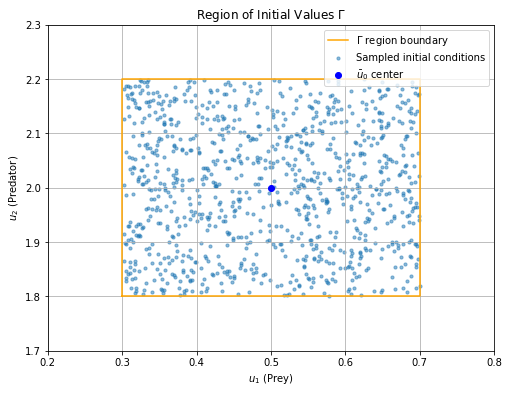

In [67]:
import numpy as np
from scipy.integrate import solve_ivp # for solving the ode
import matplotlib.pyplot as plt

# Define the Lotka-Volterra model u1 prey, u2 predator
def lotka_volterra(t, u, theta1, theta2, theta12, theta21):
    u1, u2 = u
    du1dt = theta1 * u1 - theta12 * u1 * u2
    du2dt = theta21 * u1 * u2 - theta2 * u2
    return [du1dt, du2dt]

# Parameters
theta1 = theta2 = theta12 = theta21 = 1
u0_bar = np.array([0.5, 2])
delta = 0.2
T = 6
N = 1000  # Number of Monte Carlo samples
np.random.seed(42)

## Monte Carlo simulation

# Generate samples (initial conditions) following the uniform distirbution U( [u0_bar + [-delta,delta]^2] )
initial_conditions = u0_bar + delta * (2 * np.random.rand(N, 2) - 1) # MC samples

# Define the sample (square) region vertices
square_vertices = np.array([
    [u0_bar[0] - delta, u0_bar[1] - delta],
    [u0_bar[0] + delta, u0_bar[1] - delta],
    [u0_bar[0] + delta, u0_bar[1] + delta],
    [u0_bar[0] - delta, u0_bar[1] + delta],
    [u0_bar[0] - delta, u0_bar[1] - delta]
])

# Plot the region with sampled initial conditions
plt.figure(figsize=(8, 6))
plt.plot(square_vertices[:, 0], square_vertices[:, 1], 'orange', label=r'$\Gamma$ region boundary')
plt.scatter(initial_conditions[:, 0], initial_conditions[:, 1], s=10, alpha=0.5, label='Sampled initial conditions')
plt.scatter(u0_bar[0], u0_bar[1], color='blue', zorder=5, label=r'$\bar{u}_0$ center')

plt.xlabel(r'$u_1$ (Prey)')
plt.ylabel(r'$u_2$ (Predator)')
plt.title('Region of Initial Values $\Gamma$')
plt.legend()
plt.grid(True)
plt.xlim([u0_bar[0] - delta - 0.1, u0_bar[0] + delta + 0.1])
plt.ylim([u0_bar[1] - delta - 0.1, u0_bar[1] + delta + 0.1])
plt.show()

For the next step of the MC simulation we solve the ODE for each sampled initial condition. We give a plot of the obtained function values $u_1(T)$ and mark the mean i.e. the MC estimator. 

MC estimator for expected value of u1(T) at T=6: 1.5181587659330826


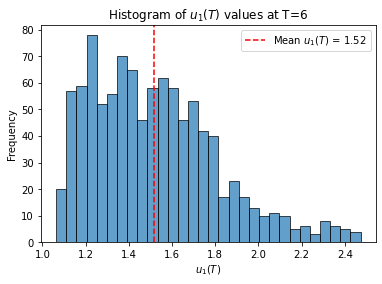

In [79]:
# Solve the ode for each initial condition
u1_T_values = [] # empty list for storing values of u1_T
for u0 in initial_conditions:
    sol = solve_ivp(lotka_volterra, [0, T], u0, args=(theta1, theta2, theta12, theta21), method='RK45', t_eval=[T])
    u1_T_values.append(sol.y[0, -1])

# Calculate MC estimator
u1_T_mean = np.mean(u1_T_values)
print(f"MC estimator for expected value of u1(T) at T={T}: {u1_T_mean}")

# Plot results
plt.hist(u1_T_values, bins=30, edgecolor='k', alpha=0.7)
plt.axvline(u1_T_mean, color='r', linestyle='--', label=f"Mean $u_{1}(T)$ = {u1_T_mean:.2f}")
plt.xlabel("$u_{1}(T)$")
plt.ylabel("Frequency")
plt.title(f"Histogram of $u_{1}(T)$ values at T={T}")
plt.legend()
plt.show()

We give now a plot of the true unperturbed trajectory (green) and ten perturbed trajectories (grey). The endpoints (blue) represent the value of $u(T)$.

Value of u1(T) for the unperturbed trajectory for T=6: u1(T)=1.4098300518931777


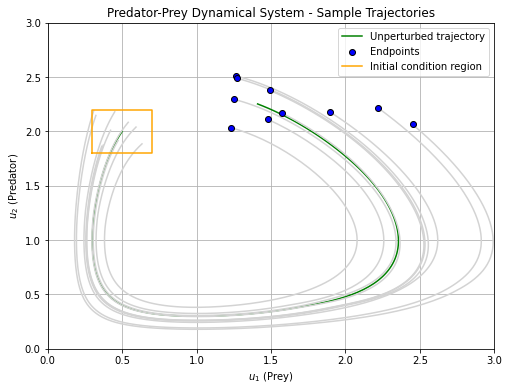

In [66]:
N = 10  # Number of perturbed trajectories
np.random.seed(42)

# Generate sampled (perturbed) initial conditions
initial_conditions = u0_bar + delta * (2 * np.random.rand(N, 2) - 1)

# Solve the ode for the unperturbed initial condition
sol_unperturbed = solve_ivp(lotka_volterra, [0, T], u0_bar, args=(theta1, theta2, theta12, theta21), method='RK45', t_eval=np.linspace(0, T, 300))
print(f"Value of u1(T) for the unperturbed trajectory for T=6: u1(T)={sol_unperturbed.y[0, -1]}")

# Solve the ode for each initial condition
trajectories = []
endpoints = []
for u0 in initial_conditions:
    sol = solve_ivp(lotka_volterra, [0, T], u0, args=(theta1, theta2, theta12, theta21), method='RK45', t_eval=np.linspace(0, T, 300))
    trajectories.append(sol)
    endpoints.append([sol.y[0, -1], sol.y[1, -1]])

endpoints = np.array(endpoints)

# Define the sample (square) region vertices
square_vertices = np.array([
    [u0_bar[0] - delta, u0_bar[1] - delta],
    [u0_bar[0] + delta, u0_bar[1] - delta],
    [u0_bar[0] + delta, u0_bar[1] + delta],
    [u0_bar[0] - delta, u0_bar[1] + delta],
    [u0_bar[0] - delta, u0_bar[1] - delta]
])

# Plot
plt.figure(figsize=(8, 6))
plt.plot(sol_unperturbed.y[0], sol_unperturbed.y[1], 'g-', label='Unperturbed trajectory') # unperturbed trajectory
for sol in trajectories:
    plt.plot(sol.y[0], sol.y[1], 'lightgray') # perturbed trajectories
plt.scatter(endpoints[:, 0], endpoints[:, 1], color='blue', edgecolor='k', zorder=5, label='Endpoints')
plt.plot(square_vertices[:, 0], square_vertices[:, 1], 'orange', label='Initial condition region')

plt.xlabel(r'$u_1$ (Prey)')
plt.ylabel(r'$u_2$ (Predator)')
plt.title('Predator-Prey Dynamical System - Sample Trajectories')
plt.legend()
plt.grid(True)
plt.xlim([0, 3])
plt.ylim([0, 3])
plt.show()

In [ ]:
# to do: add umbridge integration for predator prey

# 2. Quasi Monte Carlo Methods

## 2.1 Key Concepts

Quasi Monte Carlo (QMC) methods use (deterministic) number sequences, known as $\textit{low-discrepancy}$ sequences, instead of random sampling to achieve faster convergence rates. These sequences are designed to cover the sample space more uniformly than purely random samples.

One common low-discrepancy sequence is the Sobol sequence. We consider here the problem from section 1.2, i.e. the estimation of the integral of $f(x) = \sin(2\pi x)$ over the interval $[0,1]$.

In the following we will use the $\textit{scipy.stats.qmc}$ module to generate Sobol sequence samples and compare it to the standard MC method.

In [ ]:
# to do: add definition of sobol points

Monte Carlo mean: -0.008019332481799367
Quasi-Monte Carlo mean: 4.0172823400346937e-05
Expected mean: 0


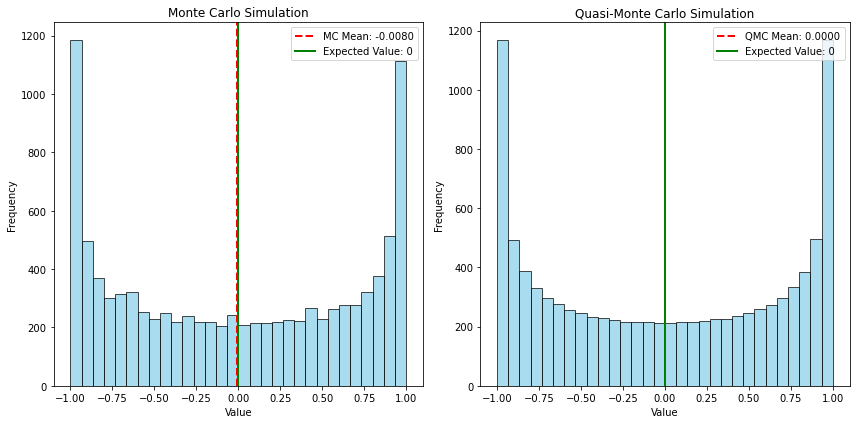

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.qmc import Sobol

# Define the function to integrate
def f(x):
    return np.sin(2 * np.pi * x)

# Number of samples
N = 10000

# Monte Carlo simulation
mc_samples = np.random.rand(N) # generate N random samples from a uniform distribution over [0, 1]
mc_values = f(mc_samples) # calculate function values of the generated samples
mc_mean = np.mean(mc_values) # calculate the mean 

# Quasi-Monte Carlo simulation using Sobol sequence
sobol_engine = Sobol(d=1, scramble=True) # initialize the Sobol sequence generator
qmc_samples = sobol_engine.random(N).flatten() # Generate N Sobol sequence samples
qmc_values = f(qmc_samples) # calculate function values of the generated samples
qmc_mean = np.mean(qmc_values)  # calculate the mean 

# Expected value (integral of sin(2*pi*x) over [0, 1])
expected_value = 0

# Plotting
plt.figure(figsize=(12, 6))

# Monte Carlo
plt.subplot(1, 2, 1)
plt.hist(mc_values, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(mc_mean, color='red', linestyle='dashed', linewidth=2, label=f'MC Mean: {mc_mean:.4f}')
plt.axvline(expected_value, color='green', linestyle='solid', linewidth=2, label='Expected Value: 0')
plt.title('Monte Carlo Simulation')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()

# Quasi-Monte Carlo
plt.subplot(1, 2, 2)
plt.hist(qmc_values, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(qmc_mean, color='red', linestyle='dashed', linewidth=2, label=f'QMC Mean: {qmc_mean:.4f}')
plt.axvline(expected_value, color='green', linestyle='solid', linewidth=2, label='Expected Value: 0')
plt.title('Quasi-Monte Carlo Simulation')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()

# Print the results
print(f"Monte Carlo mean: {mc_mean}")
print(f"Quasi-Monte Carlo mean: {qmc_mean}")
print(f"Expected mean: {expected_value}")

# Show plot
plt.tight_layout()
plt.show()

We note that the QMC method gives a closer (in terms of absolute error) estimation than the MC method.

## 2.2 UM-Bridge Integration

We give the UM-Bridge integration for a QMC client analogue to before.

In [3]:
# umbridge client
import numpy as np
import umbridge
from scipy.stats.qmc import Sobol

model = umbridge.HTTPModel("http://localhost:4242", "forward")

N = 100 # Number of samples

## Quasi Monte Carlo simulation

# Generate N Sobol sequence samples and convert them to a list
sobol_engine = Sobol(d=1, scramble=True) # initialize the Sobol sequence generator
parameters = sobol_engine.random(N).tolist()
print("First ten parameters:", parameters[:10], "\n") # print first 10 parameters

qmc_values = [model([parameters])[0][0] for parameters in parameters]  # model evaluation for each parameter
print("First ten model evaluations:", qmc_values[:10], "\n")

qmc_mean = np.mean(qmc_values)  # calculate mean
print("QMC estimator:", qmc_mean, "\n")

First ten parameters: [[0.04775118641555309], [0.9132099747657776], [0.6482893824577332], [0.2501068413257599], [0.40581345558166504], [0.5080896019935608], [0.80536288022995], [0.1713414490222931], [0.22814661264419556], [0.87339186668396]] 

First ten model evaluations: [0.2955484394832105, -0.5186898334872393, -0.8026527961908579, 0.9999997746755801, 0.5578487695093612, -0.05080658504129583, -0.9401059867225006, 0.8803360012781494, 0.9905879370721561, -0.7142153120123333] 

QMC estimator: -0.00492373204463315 

